### Data Annotation

In [1]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [3]:
import pandas as pd

In [4]:
df=pd.read_csv('cleaned_withstopwords.csv',error_bad_lines = False)


C:\Users\Haier\AppData\Local\Temp\ipykernel_5184\2858637221.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv('cleaned_withstopwords.csv',error_bad_lines = False)


In [5]:
df.drop_duplicates(inplace = True)

In [6]:
df['scores'] = df['text'].apply(lambda text: analyser.polarity_scores(text))

In [7]:
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])

In [8]:
df['sentiment'] = df['compound'].apply(lambda c: 1 if c>0 else(0 if c<0 else 2))
df.head()

,Unnamed: 0.1,Unnamed: 0,text,scores,compound,sentiment
0,0,0.0,"['i', 'think', 'it', 'gotta', 'be', 'red', 'kn...","{'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'comp...",-0.5106,0
1,1,1.0,"['the', 'ultimate', 'ense', 'of', 'accomplishm...","{'neg': 0.318, 'neu': 0.682, 'pos': 0.0, 'comp...",-0.8687,0
2,2,2.0,"['annual', 'body', 'picture', 'taken', 'for', ...","{'neg': 0.12, 'neu': 0.818, 'pos': 0.061, 'com...",-0.3818,0
3,3,3.0,"['all', 'through', 'this', 'year', 'ive', 'een...","{'neg': 0.086, 'neu': 0.705, 'pos': 0.209, 'co...",0.5719,1
4,4,4.0,"['i', 'am', 'proud', 'of', 'myself', 'for', 'g...","{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'comp...",0.9460,1


In [9]:
print("Total positive tweets:", len(df[df['sentiment']==1]), "\nTotal negative tweets:", len(df[df['sentiment']==0]))

Total positive tweets: 307292 
Total negative tweets: 298547


In [10]:
print("Total dataset lines:", len(df))

Total dataset lines: 703877


In [11]:
def percentage(part,whole):
 return 100 * float(part)/float(whole)

In [12]:
positive = percentage(len(df[df['sentiment']==1]), len(df))
negative = percentage(len(df[df['sentiment']==0]), len(df));
neutral = percentage(len(df[df['sentiment']==2]), len(df));

In [14]:
print('Positive tweets',positive)
print('Negative tweets',negative)
print('Neutral tweets',neutral)

Positive tweets 43.6570594010033
Negative tweets 42.41465483315977
Neutral tweets 13.928285765836929


### Data visualization

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive'), Text(2, 0, 'Neutral')]

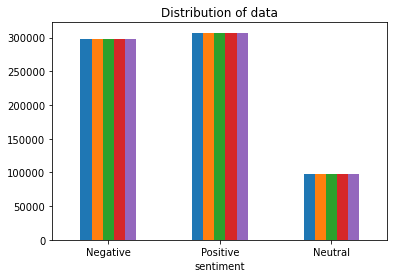

In [13]:
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive','Neutral'], rotation=0)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

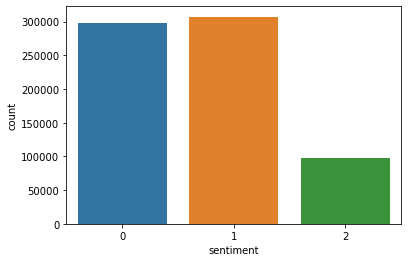

In [14]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

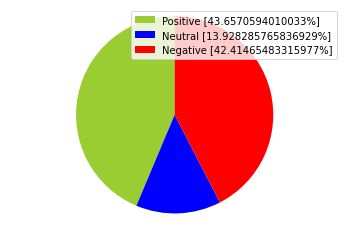

In [15]:
#Creating PieCart
import matplotlib.pyplot as plt
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.axis('equal')
plt.show()

In [16]:
df = df[df["sentiment"].eq(2) == False]

### Cloud of words

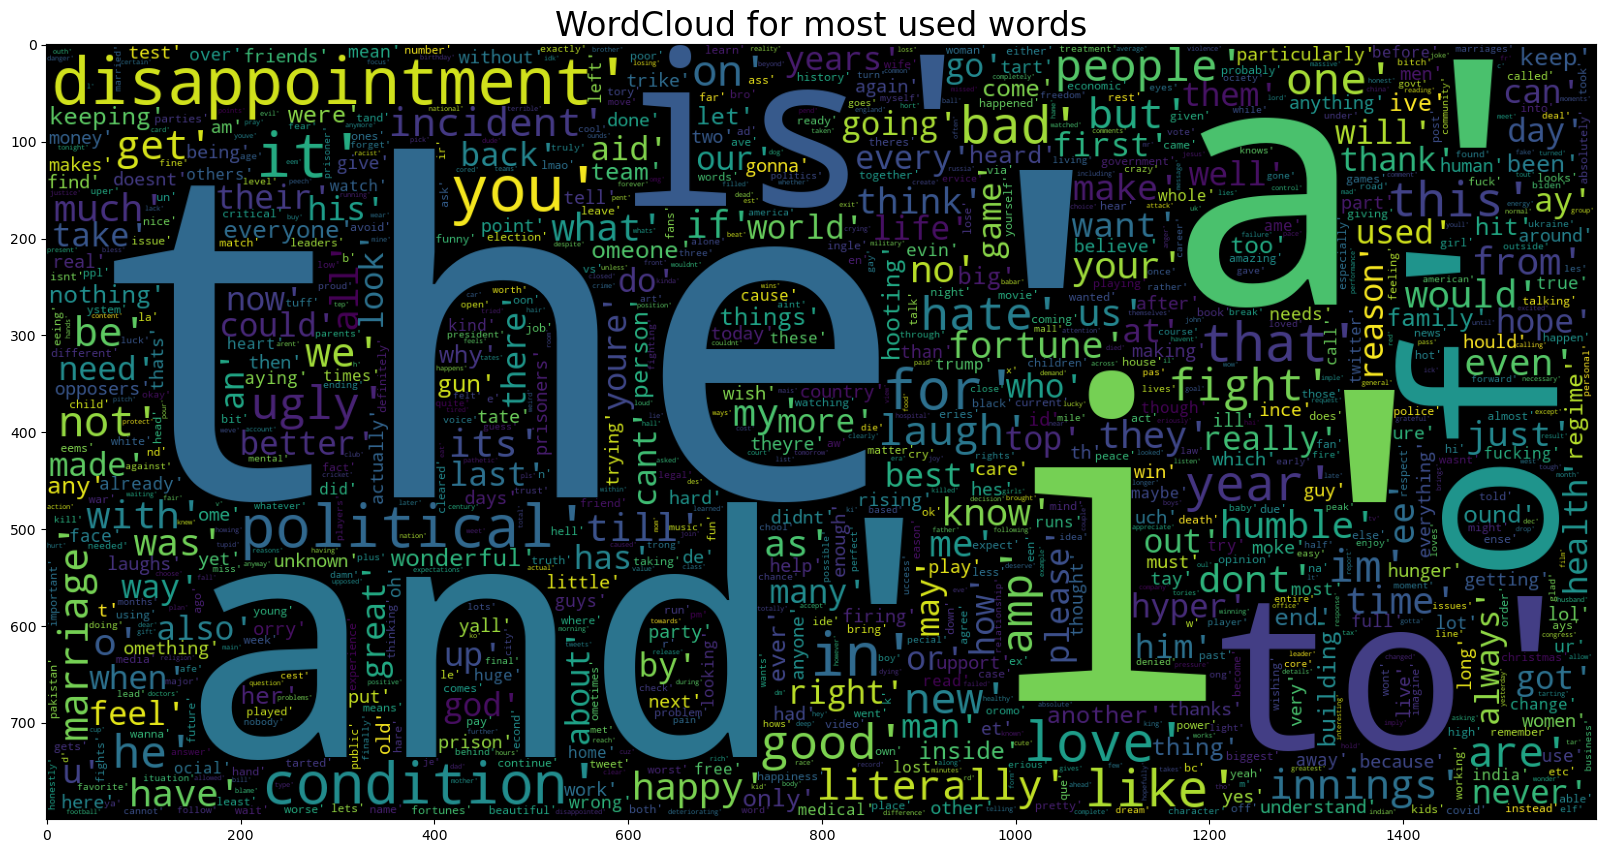

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
data = df['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data))
plt.title("WordCloud for most used words", size = 24)
plt.imshow(wc)

Text(0.5, 1.0, '30 most frequent words')

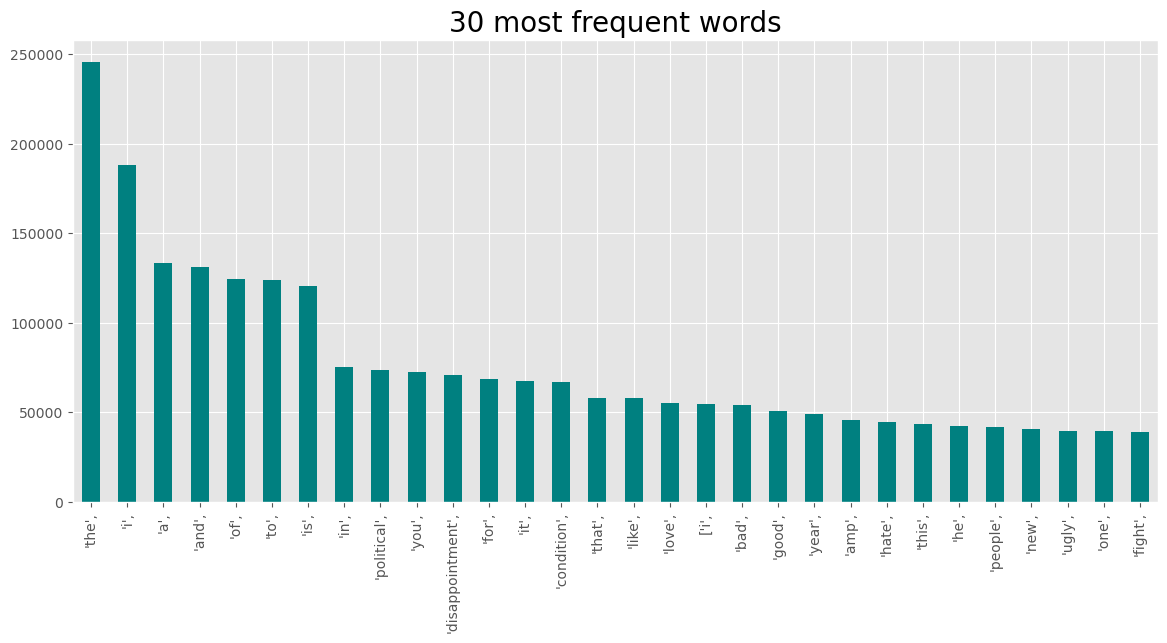

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df["text"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "teal")
plt.title("30 most frequent words",size=20)

### Feature Extraction

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
X=df.text
y=df.sentiment
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

C:\Users\Haier\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [21]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [22]:
import re
import numpy as np
import matplotlib.pyplot as plt
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Logistic Regression Model

In [23]:
from sklearn.linear_model import LogisticRegression

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     14928
           1       0.93      0.93      0.93     15364

    accuracy                           0.93     30292
   macro avg       0.93      0.93      0.93     30292
weighted avg       0.93      0.93      0.93     30292



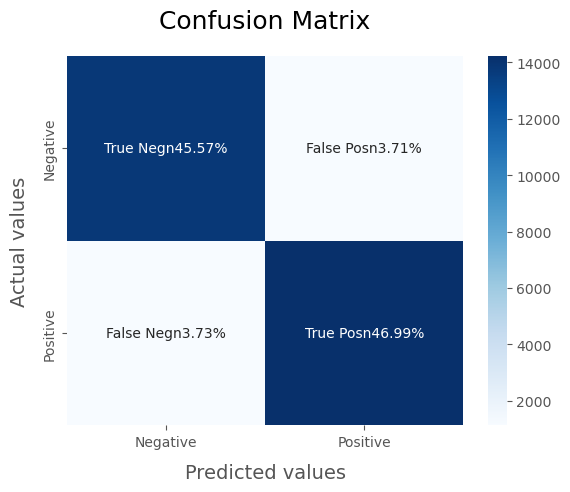

In [24]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [25]:
np.random.seed(42)

from sklearn.base import BaseEstimator, ClassifierMixin

class MyLogisticRegBinary(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.params = {}
        self.verbose = 0

    def init_params(self, X):
        """Randomly initializing parameters"""
        n_features = X.shape[1]  # number of features
        # the matrix for slope coefficients
        self.params['coef'] = np.random.randn(n_features, 1)
        # the y-intercept
        self.params['intercept'] = np.random.randn(1, 1)
        if self.verbose:
            print("[INFO] Initialized parameters.")
            print(f"Shape of coefficient matrix: {self.params['coef'].shape}")
            print(f"Shape of intercept matrix: {self.params['intercept'].shape}")

    def get_logits(self, X, y=None):
        # logits = log(odds) = X@W + b
        if 'coef' not in self.params:
            # initialize the parameters if haven't
            self.init_params(X)
        return X @ self.params['coef'] + self.params['intercept']

    def predict_proba(self, X, y=None):
        """
        Sigmoid function, aka logistic function.
        Used to get probability for binary classification.
        """
        logits = self.get_logits(X)
        return 1 / (1 + np.exp(-logits))

    def fit(self, X, y, learning_rate=0.05, iterations=1000, verbose=0):
        # set verbose to 1 to see the entire training progress
        self.verbose = verbose
        
        if isinstance(X, pd.DataFrame):
            # convert Dataframe to numpy for faster computations 
            X = X.values
        # initialize parameters
        self.init_params(X)
        m = X.shape[0]  # number of samples
    
        if verbose:
            print("[INFO] Training ...")
        for i in range(1, iterations + 1):
            # make predictions by computing probability
            y_proba = self.predict_proba(X)
            
            # calculate the binary cross-entropy loss
            loss = - (1 / m) * np.sum(y * np.log(y_proba) \
                        + (1 - y) * np.log(1 - y_proba))

            # calculate gradients via derivatives 
            #  with respect to loss function (refer above)
            dW = (1 / m) * (X.T @ (y_proba - y))
            db = (1 / m) * np.sum(y_proba - y)

            # use gradient descent to update parameters
            # parameter = parameter - (learning_rate * derivative_of_parameter)
            self.params['coef'] -= (learning_rate * dW)
            self.params['intercept'] -= (learning_rate * db)
            
            if verbose and (i == 1 or i % 100 == 0):
                print(f"\nIteration {i}/{iterations}")
                print("--" * 12)
                print(f"Loss: {loss}")
                print(f"Coefficient:\n{self.params['coef']}")
                print(f"Intercept:\n{self.params['intercept']}")

    def predict(self, X, threshold=0.5):
        y_proba = self.predict_proba(X)
        y_pred = np.where(y_proba > threshold, 1, 0)
        return y_pred
    
    def predict_score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
 




              precision    recall  f1-score   support

           0       0.52      0.51      0.51     14928
           1       0.53      0.54      0.53     15364

    accuracy                           0.53     30292
   macro avg       0.52      0.52      0.52     30292
weighted avg       0.53      0.53      0.53     30292



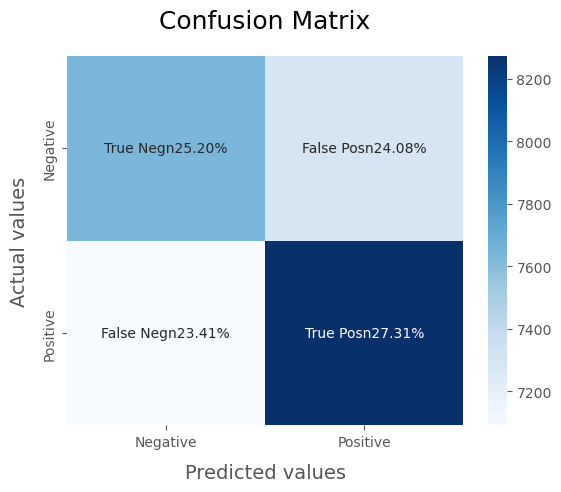

In [26]:

from sklearn.preprocessing import MaxAbsScaler
my_log_reg = MyLogisticRegBinary()
scaler = MaxAbsScaler()
scaledTrainX= scaler.fit_transform(X_train)
y_train=y_train.values.reshape(-1,1)
scaledTestX = scaler.fit_transform(y_train)
my_log_reg.fit(X_train, y_train, learning_rate=0.05, iterations=1000, verbose=0)
y_pred = my_log_reg.predict(X_test)
model_Evaluate(my_log_reg)
